In [1]:
import pandas as pd
import numpy as np
import pylab as plt
%matplotlib inline

In [15]:
data = pd.read_csv('data/Test1.csv')
data

,sats,time,lat,long,velocity,heading,height,vert-vel,yaw-calc,slip,YAW__,YAW_,Unnamed: 12
0,8,"073910,50","+02473,74133","-00100,58397","000,000","000,00","+00102,45","+000,000","+000,0","+0,00000E+00","+0,00000E+00","+0,00000E+00",NaN
1,8,"073910,60","+02473,74133","-00100,58397","000,000","280,68","+00102,45","+000,000","+000,0","+0,00000E+00","+0,00000E+00","+0,00000E+00",NaN
2,8,"073910,70","+02473,74133","-00100,58396","000,000","154,27","+00102,45","+000,000","+000,0","+0,00000E+00","+0,00000E+00","+0,00000E+00",NaN
3,8,"073910,80","+02473,74133","-00100,58396","000,000","154,27","+00102,45","+000,000","+000,0","+0,00000E+00","+0,00000E+00","+0,00000E+00",NaN
4,8,"073910,90","+02473,74134","-00100,58395","000,000","303,40","+00102,45","+000,000","+000,0","+0,00000E+00","+0,00000E+00","+0,00000E+00",NaN
5,8,"073911,00","+02473,74134","-00100,58395","000,000","075,39","+00102,46","+000,000","+000,0","+0,00000E+00","+0,00000E+00","+0,00000E+00",NaN
6,8,"073911,10","+02473,74134","-00100,58394","000,000","225,76","+00102,46","+000,000","+000,0","+0,00000E+00","+0,00000E+00","+0,00000E+00",NaN
7,8,"073911,20","+02473,74134","-00100,58394","000,000","225,76","+00102,46","+000,000","+000,0","+0,00000E+00","+0,00000E+00","+0,00000E+00",NaN
8,8,"073911,30","+02473,74134","-00100,58394","000,000","225,76","+00102,46","+000,000","+000,0","+0,00000E+00","+0,00000E+00","+0,00000E+00",NaN
9,8,"073911,40","+02473,74134","-00100,58394","000,000","087,81","+00102,47","+000,000","+000,0","+0,00000E+00","+0,00000E+00","+0,00000E+00",NaN


In [41]:
for head in data:
    if 'object:dense' in data[head].ftypes:
        data[head] = data[head].apply(lambda x: x.replace(',', '.').replace('+', ''))
        data[head] = data[head].astype(float)
data.ftypes, data

(sats             int64:dense
 time           float64:dense
 lat            float64:dense
 long           float64:dense
 velocity       float64:dense
 heading        float64:dense
 height         float64:dense
 vert-vel       float64:dense
 yaw-calc       float64:dense
 slip           float64:dense
 YAW__          float64:dense
 YAW_           float64:dense
 Unnamed: 12    float64:dense
 dtype: object,
       sats     time         lat       long  velocity  heading  height  \
 0        8  73910.5  2473.74133 -100.58397      0.00     0.00  102.45   
 1        8  73910.6  2473.74133 -100.58397      0.00   280.68  102.45   
 2        8  73910.7  2473.74133 -100.58396      0.00   154.27  102.45   
 3        8  73910.8  2473.74133 -100.58396      0.00   154.27  102.45   
 4        8  73910.9  2473.74134 -100.58395      0.00   303.40  102.45   
 5        8  73911.0  2473.74134 -100.58395      0.00    75.39  102.46   
 6        8  73911.1  2473.74134 -100.58394      0.00   225.76  102.46   
 7

TypeError: Empty 'DataFrame': no numeric data to plot

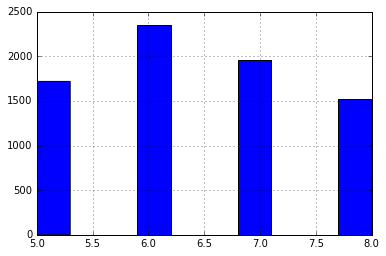

In [20]:
data['sats'].hist().plot()
data['long'].plot()